# StyleGAN2
*Please note that this is an optional notebook that is meant to introduce more advanced concepts, if you're up for a challenge. So, don't worry if you don't completely follow every step! We provide external resources for extra base knowledge required to grasp some components of the advanced material.*

In this notebook, you're going to learn about StyleGAN2, from the paper [Analyzing and Improving the Image Quality of StyleGAN](https://arxiv.org/abs/1912.04958) (Karras et al., 2019), and how it builds on StyleGAN. This is the V2 of StyleGAN, so be prepared for even more extraordinary outputs. Here's the quick version: 

1. **Demodulation.** The instance normalization of AdaIN in the original StyleGAN actually was producing “droplet artifacts” that made the output images clearly fake. AdaIN is modified a bit in StyleGAN2 to make this not happen. Below, *Figure 1* from the StyleGAN2 paper is reproduced, showing the droplet artifacts in StyleGAN. 

![droplet artifacts example](https://drive.google.com/uc?id=1MnW75c-vRk_O3iDqCxPXzFjg_jniYxWo)

2. **Path length regularization.** “Perceptual path length” (or PPL, which you can explore in [another optional notebook](https://www.coursera.org/learn/build-better-generative-adversarial-networks-gans/ungradedLab/BQjUq/optional-ppl)) was introduced in the original StyleGAN paper, as a metric for measuring the disentanglement of the intermediate noise space W. PPL measures the change in the output image, when interpolating between intermediate noise vectors $w$. You'd expect a good model to have a smooth transition during interpolation, where the same step size in $w$ maps onto the same amount of perceived change in the resulting image. 

  Using this intuition, you can make the mapping from $W$ space to images smoother, by  encouraging a given change in $w$ to correspond to a constant amount of change in the image. This is known as path length regularization, and as you might expect, included as a term in the loss function. This smoothness also made the generator model "significantly easier to invert"! Recall that inversion means going from a real or fake image to finding its $w$, so you can easily adapt the image's styles by controlling $w$.


3. **No progressive growing.** While progressive growing was seemingly helpful for training the network more efficiently and with greater stability at lower resolutions before progressing to higher resolutions, there's actually a better way. Instead, you can replace it with 1) a better neural network architecture with skip and residual connections (which you also see in Course 3 models, Pix2Pix and CycleGAN), and 2) training with all of the resolutions  at once, but gradually moving the generator's _attention_ from lower-resolution to higher-resolution dimensions. So in a way, still being very careful about how to handle different resolutions to make training eaiser, from lower to higher scales.

There are also a number of performance optimizations, like calculating the regularization less frequently. We won't focus on those in this notebook, but they are meaningful technical contributions. 


But first, some useful imports:

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_tensor_images(image_tensor, num_images=16, size=(3, 64, 64), nrow=3):
    '''
    Function for visualizing images: Given a tensor of images, number of images,
    size per image, and images per row, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu().clamp_(0, 1)
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow, padding=2)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.axis('off')
    plt.show()

## Fixing Instance Norm
One issue with instance normalization is that it can lose important information that is typically communicated by relative magnitudes. In StyleGAN2, it was proposed that the droplet artifects are a way for the network to "sneak" this magnitude information with a single large spike. This issue was also highlighted in the paper which introduced GauGAN, [Semantic Image Synthesis with Spatially-Adaptive Normalization](https://arxiv.org/abs/1903.07291) (Park et al.), earlier in 2019. In that more extreme case, instance normalization could sometimes eliminate all semantic information, as shown in their paper's *Figure 3*: 

![information loss by gaugan](https://drive.google.com/uc?id=1qVWI_c5ONS9yAseX9GvnYmQ4p_ZpiOG1)


While removing normalization is technically possible, it reduces the controllability of the model, a major feature of StyleGAN. Here's one solution from the paper:

### Output Demodulation
The first solution notes that the scaling the output of a convolutional layer by style has a consistent and numerically reproducible impact on the standard deviation of its output. By scaling down the standard deviation of the output to 1, the droplet effect can be reduced. 

More specifically, the style $s$, when applied as a multiple to convolutional weights $w$, resulting in weights $w'_{ijk}=s_i \cdot w_{ijk}$ will have standard deviation $\sigma_j = \sqrt{\sum_{i,k} w'^2_{ijk}}$. One can simply divide the output of the convolution by this factor. 

However, the authors note that dividing by this factor can also be incorporated directly into the the convolutional weights (with an added $\epsilon$ for numerical stability):

$$w''_{ijk}=\frac{w'_{ijk}}{\sqrt{\sum_{i,k} w'^2_{ijk} + \epsilon}}$$

This makes it so that this entire operation can be baked into a single convolutional layer, making it easier to work with, implement, and integrate into the existing architecture of the model.


Original noise (left), noise after modulated convolution (middle), noise after two modulated convolutions (right)


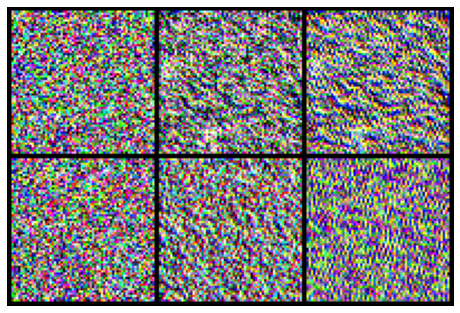

In [3]:
class ModulatedConv2d(nn.Module):
    '''
    ModulatedConv2d Class, extends/subclass of nn.Module
    Values:
      channels: the number of channels the image has, a scalar
      w_dim: the dimension of the intermediate tensor, w, a scalar 
    '''

    def __init__(self, w_dim, in_channels, out_channels, kernel_size, padding=1):
        super().__init__()
        self.conv_weight = nn.Parameter(
            torch.randn(out_channels, in_channels, kernel_size, kernel_size)
        )
        self.style_scale_transform = nn.Linear(w_dim, in_channels)
        self.eps = 1e-6
        self.padding = padding

    def forward(self, image, w):
        # There is a more efficient (vectorized) way to do this using the group parameter of F.conv2d,
        # but for simplicity and readibility you will go through one image at a time.
        images = []
        for i, w_cur in enumerate(w):
            # Calculate the style scale factor
            style_scale = self.style_scale_transform(w_cur)
            # Multiply it by the corresponding weight to get the new weights
            w_prime = self.conv_weight * style_scale[None, :, None, None]
            # Demodulate the new weights based on the above formula
            w_prime_prime = w_prime / torch.sqrt(
                (w_prime ** 2).sum([1, 2, 3])[:, None, None, None] + self.eps
            )
            images.append(F.conv2d(image[i][None], w_prime_prime, padding=self.padding))
        return torch.cat(images)
    
    def forward_efficient(self, image, w):
        # Here's the more efficient approach. It starts off mostly the same
        style_scale = self.style_scale_transform(w)
        w_prime = self.conv_weight[None] * style_scale[:, None, :, None, None]
        w_prime_prime = w_prime / torch.sqrt(
            (w_prime ** 2).sum([2, 3, 4])[:, :, None, None, None] + self.eps
        )
        # Now, the trick is that we'll make the images into one image, and 
        # all of the conv filters into one filter, and then use the "groups"
        # parameter of F.conv2d to apply them all at once
        batchsize, in_channels, height, width = image.shape
        out_channels = w_prime_prime.shape[2]
        # Create an "image" where all the channels of the images are in one sequence
        efficient_image = image.view(1, batchsize * in_channels, height, width)
        efficient_filter = w_prime_prime.view(batchsize * out_channels, in_channels, *w_prime_prime.shape[3:])
        efficient_out = F.conv2d(efficient_image, efficient_filter, padding=self.padding, groups=batchsize)
        return efficient_out.view(batchsize, out_channels, *image.shape[2:])

example_modulated_conv = ModulatedConv2d(w_dim=128, in_channels=3, out_channels=3, kernel_size=3)
num_ex = 2
image_size = 64
rand_image = torch.randn(num_ex, 3, image_size, image_size) # A 64x64 image with 3 channels
rand_w = torch.randn(num_ex, 128)
new_image = example_modulated_conv(rand_image, rand_w)
second_modulated_conv = ModulatedConv2d(w_dim=128, in_channels=3, out_channels=3, kernel_size=3)
second_image = second_modulated_conv(new_image, rand_w)

print("Original noise (left), noise after modulated convolution (middle), noise after two modulated convolutions (right)")
plt.rcParams['figure.figsize'] = [8, 8]
show_tensor_images(torch.stack([rand_image, new_image, second_image], 1).view(-1, 3, image_size, image_size))

## Path Length Regularization

Path length regularization was introduced based on the usefulness of PPL, or perceptual path length, a metric used of evaluating disentanglement proposed in the original StyleGAN paper -- feel free to check out the [optional notebook](https://www.coursera.org/learn/build-better-generative-adversarial-networks-gans/ungradedLab/BQjUq/optional-ppl) for a detailed overview! In essence, for a fixed-size step in any direction in $W$ space, the metric attempts to make the change in image space to have a constant magnitude $a$. This is accomplished (in theory) by first taking the Jacobian of the generator with respect to $w$, which is $\mathop{\mathrm{J}_{\mathrm{w}}}={\partial g(\mathrm{w})} / {\partial \mathrm{w}}$. 

Then, you take the L2 norm of Jacobian matrix and you multiply that by random images (that you sample from a normal distribution, as you often do): 
$\Vert \mathrm{J}_{\mathrm{w}}^T \mathrm{y} \Vert_2$. This captures the expected magnitude of the change in pixel space. From this, you get a loss term, which penalizes the distance between this magnitude and $a$. The paper notes that this has similarities to spectral normalization (discussed in [another optional notebook](https://www.coursera.org/learn/build-basic-generative-adversarial-networks-gans/ungradedLab/c2FPs/optional-sn-gan) in Course 1), because it constrains multiple norms. 

An additional optimization is also possible and ultimately used in the StyleGAN2 model: instead of directly computing $\mathrm{J}_{\mathrm{w}}^T \mathrm{y}$, you can more efficiently calculate the gradient 
$\nabla_{\mathrm{w}} (g(\mathrm{w}) \cdot \mathrm{y})$.

Finally, a bit of talk on $a$: $a$ is not a fixed constant, but an exponentially decaying average of the magnitudes over various runs -- as with most times you see (decaying) averages being used, this is to smooth out the value of $a$ across multiple iterations, not just dependent on one. Notationally, with decay rate $\gamma$, $a$ at the next iteration $a_{t+1} = {a_t} * (1 - \gamma) + \Vert \mathrm{J}_{\mathrm{w}}^T \mathrm{y} \Vert_2 * \gamma$. 

However, for your one example iteration you can treat $a$ as a constant for simplicity. There is also an example of an update of $a$ after the calculation of the loss, so you can see what $a_{t+1}$ looks like with exponential decay.

In [4]:
# For convenience, we'll define a very simple generator here:
class SimpleGenerator(nn.Module):
    '''
    SimpleGenerator Class, for path length regularization demonstration purposes
    Values:
      channels: the number of channels the image has, a scalar
      w_dim: the dimension of the intermediate tensor, w, a scalar 
    '''

    def __init__(self, w_dim, in_channels, hid_channels, out_channels, kernel_size, padding=1, init_size=64):
        super().__init__()
        self.w_dim = w_dim
        self.init_size = init_size
        self.in_channels = in_channels
        self.c1 = ModulatedConv2d(w_dim, in_channels, hid_channels, kernel_size)
        self.activation = nn.ReLU()
        self.c2 = ModulatedConv2d(w_dim, hid_channels, out_channels, kernel_size)

    def forward(self, w):
        image = torch.randn(len(w), self.in_channels, self.init_size, self.init_size).to(w.device)
        y = self.c1(image, w)
        y = self.activation(y)
        y = self.c2(y, w)
        return y

In [5]:
from torch.autograd import grad
def path_length_regulization_loss(generator, w, a):
    # Generate the images from w
    fake_images = generator(w)
    # Get the corresponding random images
    random_images = torch.randn_like(fake_images)
    # Output variation that we'd like to regularize
    output_var = (fake_images * random_images).sum()
    # Calculate the gradient with respect to the inputs
    cur_grad = grad(outputs=output_var, inputs=w)[0]
    # Calculate the distance from a
    penalty = (((cur_grad - a) ** 2).sum()).sqrt()
    return penalty, output_var
simple_gen = SimpleGenerator(w_dim=128, in_channels=3, hid_channels=64, out_channels=3, kernel_size=3)
samples = 10
test_w = torch.randn(samples, 128).requires_grad_()
a = 10
penalty, variation = path_length_regulization_loss(simple_gen, test_w, a=a)

decay = 0.001 # How quickly a should decay
new_a = a * (1 - decay) + variation * decay
print(f"Old a: {a}; new a: {new_a.item()}")

Old a: 10; new a: 10.02370548248291


## No More Progressive Growing
While the concepts behind progressive growing remain, you get to see how that is revamped and beefed up in StyleGAN2. This starts with generating all resolutions of images from the very start of training. You might be wondering why they didn't just do this in the first place: in the past, this has generally been unstable to do. However, by using residual or skip connections (there are two variants that both do better than without them), StyleGAN2 manages to replicate many of the dynamics of progressive growing in a less explicit way. Three architectures were considered for StyleGAN2 to replace the progressive growing. 

Note that in the following figure, *tRGB* and *fRGB* refer to the $1 \times 1$ convolutions which transform the noise with some number channels at a given layer into a three-channel image for the generator, and vice versa for the discriminator.

![architectures considered](https://drive.google.com/uc?id=1oueHeMeZAmaXBsZw1r8ZTRp8o3Zzlqzp)

*The set of architectures considered for StyleGAN2 (from the paper). Ultimately, the skip generator and residual discriminator (highlighted in green) were chosen*.

### Option a: MSG-GAN
[MSG-GAN](https://arxiv.org/abs/1903.06048) (from Karnewar and Wang 2019), proposed a somewhat natural approach: generate all resolutions of images, but also directly pass each corresponding resolution to a block of the discriminator responsible for dealing with that resolution. 

### Option b: Skip Connections

In the skip-connection approach, each block takes the previous noise as input and generates the next resolution of noise. For the generator, each noise is converted to an image, upscaled to the maximum size, and then summed together. For the discriminator, the images are downsampled to each block's size and converted to noises.

### Option c: Residual Nets

In the residual network approach, each block adds residual detail to the noise, and the image conversion happens at the end for the generator and at the start for the discriminator.

### StyleGAN2: Skip Generator, Residual Discriminator
By experiment, the skip generator and residual discriminator were chosen. One interesting effect is that, as the images for the skip generator are additive, you can explicitly see the contribution from each of them, and measure the magnitude of each block's contribution. If you're not 100% sure how to implement skip and residual models yet, don't worry - you'll get a lot of practice with that in Course 3!

![contribution by different resolutions over time](https://drive.google.com/uc?id=1qqVzB74auJa4ks-E4HfriaPK_3EgN_Cy)

*Figure 8 from StyleGAN2 paper, showing generator contributions by different resolution blocks of the generator over time. The y-axis is the standard deviation of the contributions, and the x-axis is the number of millions of images that the model has been trained on (training progress).*

Now, you've seen the primary changes, and you understand the current state-of-the-art in image generation, StyleGAN2, congratulations! 

If you're the type of person who reads through the optional notebooks for fun, maybe you'll make the next state-of-the-art! Can't wait to cover your GAN in a new notebook :)